In [8]:
# Next steps:
# 1) DONE - normalise generation (days in month, gross generation, degradation)
# 2) plot correlation
# 3) remove outliers
# 4) linear fit and synthesise generation
# 5) LT corrections
# 6) P50 output with availability shown

# Improvements:
# Done - ERA5 download for whole of world to speed up results
# EIA download for all plants to speed up results
# MERRA2 included as well
# Cover wind and solar
# Degradation analysis
# Simple front-end
# Examples
# Documentation
# Extend to other open generation datasets 

In [9]:
# load system packages
import os
from pathlib import Path

# load custom packages (requirements)
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt

# load local packages
from downloader import get_era5_monthly, get_EIA_plant_information, get_EIA_plant_generation

# load environment variables
load_dotenv()
EIA_API_KEY = os.environ["EIA_API_KEY"]



In [10]:
# get EIA plant information for wind assets
plant_info_file=Path("data/plant_list.csv").resolve()
if not plant_info_file.is_file():
    df_plant = get_EIA_plant_information(EIA_API_KEY)
    df_plant.to_csv(plant_info_file)
else:
    df_plant = pd.read_csv(plant_info_file)

print(df_plant)



      Unnamed: 0   period stateid   stateName       sector   sectorName  \
0              0  2023-05      TX       Texas  ipp-non-chp  IPP Non-CHP   
1              1  2023-05      IL    Illinois  ipp-non-chp  IPP Non-CHP   
2              2  2023-05      IL    Illinois  ipp-non-chp  IPP Non-CHP   
3              3  2023-05      NM  New Mexico  ipp-non-chp  IPP Non-CHP   
4              4  2023-05      NM  New Mexico  ipp-non-chp  IPP Non-CHP   
...          ...      ...     ...         ...          ...          ...   
1518        1518  2023-05      MI    Michigan  ipp-non-chp  IPP Non-CHP   
1519        1519  2023-05      KS      Kansas  ipp-non-chp  IPP Non-CHP   
1520        1520  2023-05      KS      Kansas  ipp-non-chp  IPP Non-CHP   
1521        1521  2023-05      KS      Kansas  ipp-non-chp  IPP Non-CHP   
1522        1522  2023-05      TX       Texas  ipp-non-chp  IPP Non-CHP   

      entityid                          entityName  plantid  \
0        58998              Chapman 

In [11]:
# select an EIA plant for analysis
selected_plant = df_plant.iloc[1]
print(selected_plant)


Unnamed: 0                                                 1
period                                               2023-05
stateid                                                   IL
stateName                                           Illinois
sector                                           ipp-non-chp
sectorName                                       IPP Non-CHP
entityid                                               56421
entityName                       Blackstone Wind Farm II LLC
plantid                                                57113
plantName                        Blackstone Wind Farm II LLC
generatorid                                            GEN 1
technology                              Onshore Wind Turbine
energy_source_code                                       WND
energy-source-desc                                      Wind
prime_mover_code                                          WT
balancing_authority_code                                 PJM
balancing-authority-name

In [ ]:

# get the EIA generation for the selected plant
plant_data_file=Path(f"data/plant_generation_{selected_plant['plantid']}.csv").resolve()
if not plant_data_file.is_file():
    df_generation = get_EIA_plant_generation(EIA_API_KEY,plantCode=selected_plant["plantid"])
    df_generation.to_csv(plant_data_file)
else:
    df_generation = pd.read_csv(plant_data_file)

# set index to converted datetime
df_generation = df_generation.set_index("period")
df_generation.index = pd.to_datetime(df_generation.index)
print(df_generation)



In [12]:
# get era5 data for the selected plant
df_era5 = get_era5_monthly(
    lat=selected_plant["latitude"],
    lon=selected_plant["longitude"]%360,
    save_pathname="data",
    save_filename=selected_plant["plantid"],
    data_pathname="data/era5_monthly",
    data_filename="era5_monthly",
    start_date="2000-01",
)

print(df_era5)

            windspeed_ms
datetime                
2000-01-01      4.219223
2000-02-01      4.407962
2000-03-01      3.918223
2000-04-01      3.929246
2000-05-01      4.040654
...                  ...
2023-04-01      4.373532
2023-05-01      3.557866
2023-06-01      3.409114
2023-07-01      2.631998
2023-08-01      3.138621

[284 rows x 1 columns]


In [13]:
# combine wind speed and generation into single dataframe
df = pd.concat([df_era5[["windspeed_ms"]],df_generation[["generation","gross-generation"]]],axis=1)

# add days in month column
df["days-in-month"] = df.index.to_series().dt.days_in_month

# add availability column
df["availability-reported"] = df["generation"]/df["gross-generation"]

# add normalised generation column
df["generation-normalised"] = df["gross-generation"]*30/df["days-in-month"]

print(df.tail(20))


            windspeed_ms  generation  gross-generation
2022-01-01      4.217452         NaN               NaN
2022-02-01      4.733000         NaN               NaN
2022-03-01      4.332559         NaN               NaN
2022-04-01      4.956857         NaN               NaN
2022-05-01      4.301798         NaN               NaN
2022-06-01      3.333897         NaN               NaN
2022-07-01      3.147700         NaN               NaN
2022-08-01      3.021332         NaN               NaN
2022-09-01      3.233796         NaN               NaN
2022-10-01      4.139996         NaN               NaN
2022-11-01      4.610225         NaN               NaN
2022-12-01      4.444456         NaN               NaN
2023-01-01      3.741932         NaN               NaN
2023-02-01      4.496227         NaN               NaN
2023-03-01      4.408937         NaN               NaN
2023-04-01      4.373532         NaN               NaN
2023-05-01      3.557866         NaN               NaN
2023-06-01

<Axes: xlabel='windspeed_ms', ylabel='generation-normalised'>

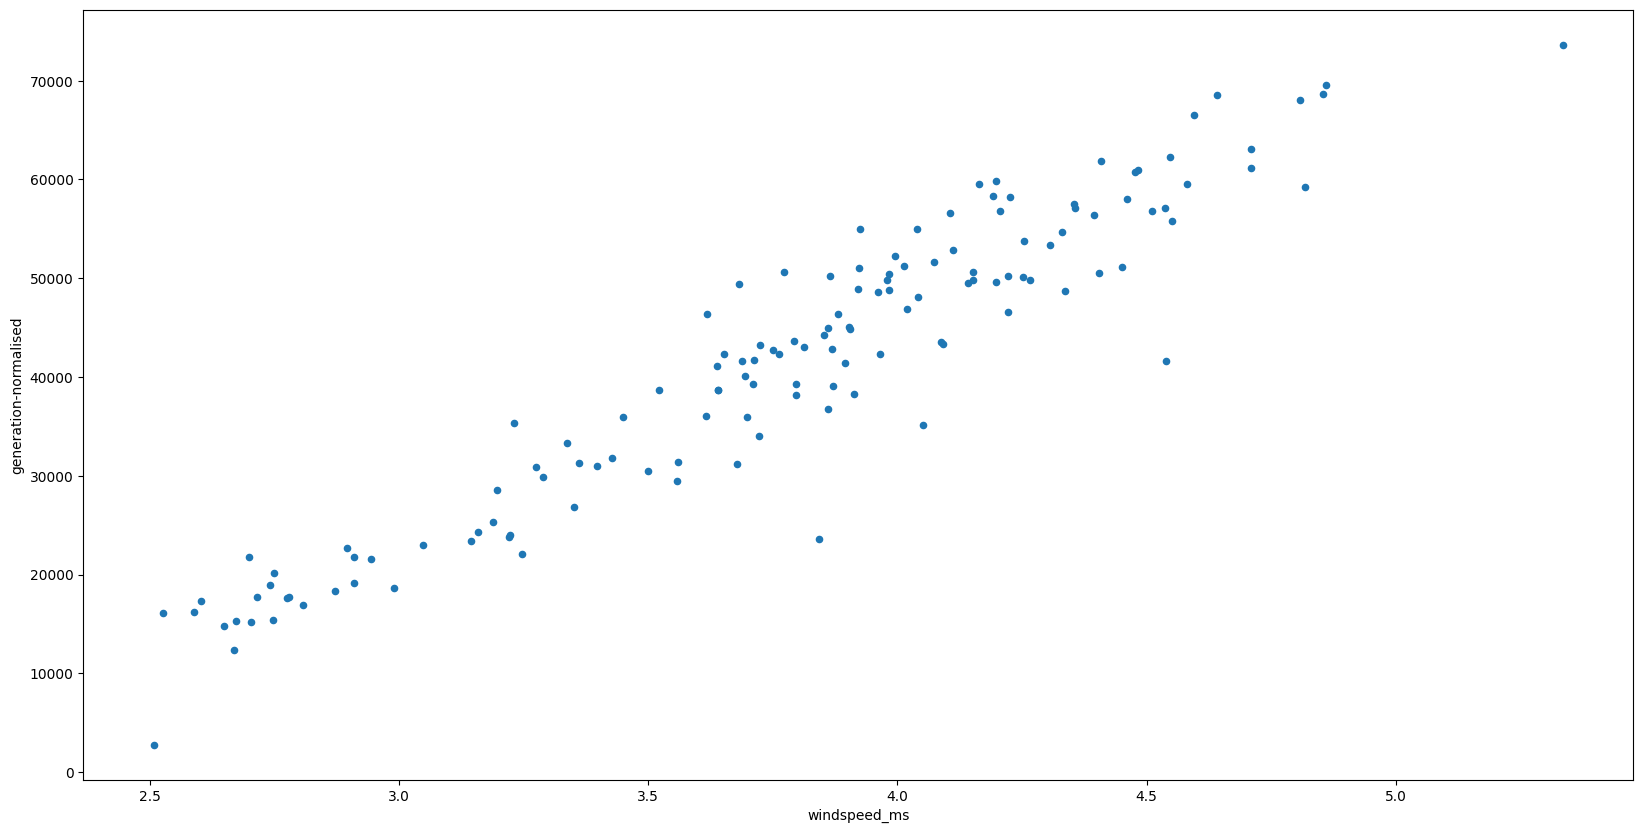

In [14]:

# fig, ax = plt.subplots(figsize=(20,10)) 
# df.plot(y = "generation", ax = ax) 
# df.plot(y = "gross-generation", ax = ax) 
# df.plot(y = "windspeed_ms", ax = ax, secondary_y = True) 
# plt.show()

fig, ax = plt.subplots(figsize=(20,10)) 
df.plot.scatter(x="windspeed_ms",y="generation-normalised",ax=ax)
